Código Geral

In [221]:
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
import ast
from collections import Counter
from pandas import DataFrame

sns.set_theme()


start_year = 2013
end_year = 2023

movies_data_by_year = {}


In [222]:
def get_file_path(year):
    data_common_name = 'prepared_data/tmdb_dump'
    return f'{data_common_name}-{year}.csv'

def read_data_set(year):
    file_path = get_file_path(year)
    return pd.read_csv(file_path, encoding='utf-8', lineterminator='\n')

In [223]:
for year in range(start_year, end_year+1):
    data = read_data_set(year)
    movies_data_by_year[year] = data
    if 'all' in movies_data_by_year:
        movies_data_by_year['all'] = pd.concat([movies_data_by_year['all'], data])
    else:
        movies_data_by_year['all'] = data

Análise dos Dados numéricos (Quantidade e Média)

In [224]:
def movies_count(year):
    df =  movies_data_by_year[year]
    return len(df.index)

def budget_mean(year):
    df: DataFrame = movies_data_by_year[year]
    return df.loc[:, 'budget'].mean()

def revenue_mean(year):
    df: DataFrame = movies_data_by_year[year]
    return df.loc[:, 'revenue'].mean()

def runtime_mean(year):
    df: DataFrame = movies_data_by_year[year]
    return df.loc[:, 'runtime'].mean()

def vote_count_mean(year):
    df: DataFrame = movies_data_by_year[year]
    return df.loc[:, 'vote_count'].mean()

def vote_mean_by_year(year):
    df: DataFrame = movies_data_by_year[year]
    return vote_mean(df)

def vote_mean(df):
    df["weight"] = df["vote_count"] * df["vote_average"]
    return df["weight"].sum() / df["vote_count"].sum()
    
def vote_deviation(df):
    mean = vote_mean(df)
    df["weight"] = df["vote_count"] * df["vote_average"]    
    df["deviation"] = ((df["vote_average"] - mean)**2) * df["weight"]
    
    upper_eq_part = df["deviation"].sum()
    
    weight_sum = df["weight"].sum()
    n = df["weight"].count()
    bottom_eq_part = weight_sum * (n - 1) / n
    
    return math.sqrt(upper_eq_part/bottom_eq_part)

Calculo do desvio padrão amostral dos dados numéricos

In [225]:
df_concat = movies_data_by_year[start_year]
for year in range(start_year+1, end_year+1):
    df_concat = pd.concat([df_concat, movies_data_by_year[year]])
    
numeric_columns = ["budget", "revenue", "runtime", "vote_count"]
print(df_concat[numeric_columns].std())
print("Deviation: ", vote_deviation(df_concat))


budget        5.004297e+07
revenue       2.163519e+08
runtime       2.107148e+01
vote_count    3.680442e+03
dtype: float64
Deviation:  0.7151867182957711


In [226]:
for year in range(start_year, end_year+1):
    values = year, movies_count(year), budget_mean(year), revenue_mean(year), runtime_mean(year), vote_count_mean(year), vote_mean_by_year(year)
    for value in values:
        print("{:.2f}".format(value), " & " , end="")
    print("")


2013.00  & 333.00  & 29133697.35  & 83963872.83  & 111.97  & 2356.57  & 6.79  & 
2014.00  & 317.00  & 27739095.79  & 88809630.21  & 109.73  & 2624.77  & 7.01  & 
2015.00  & 301.00  & 28413424.29  & 96225236.56  & 112.00  & 2407.86  & 6.81  & 
2016.00  & 339.00  & 30959884.17  & 92686166.47  & 111.99  & 2464.51  & 6.83  & 
2017.00  & 307.00  & 29728204.99  & 103942389.76  & 112.44  & 2593.88  & 6.96  & 
2018.00  & 275.00  & 30404534.53  & 109654092.13  & 112.82  & 2334.57  & 7.00  & 
2019.00  & 251.00  & 32862991.07  & 119087300.21  & 111.95  & 2376.76  & 7.14  & 
2020.00  & 132.00  & 26047200.65  & 39661077.16  & 105.89  & 1539.45  & 7.04  & 
2021.00  & 158.00  & 45537524.30  & 93868823.13  & 115.16  & 2124.64  & 7.21  & 
2022.00  & 173.00  & 39368203.98  & 105105561.14  & 115.13  & 1499.87  & 7.11  & 
2023.00  & 207.00  & 44851926.51  & 106455189.39  & 117.57  & 1097.42  & 7.14  & 


Mapas coropléticos

In [227]:
import numpy as np
import folium
import geopandas as gpd
from folium import Choropleth

for year in range (start_year, end_year+1):
    df = movies_data_by_year[year]
    df['production_countries'] = df['production_countries'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    df_countries = df.explode('production_countries', ignore_index=True)
    country_counts = df_countries['production_countries'].value_counts().reset_index()
    country_counts.columns = ['production_country', 'count']
    country_counts['count'] = np.log(country_counts['count'])

    # Carrega o arquivo GeoJSON com as fronteiras dos países
    geo_json_data = gpd.read_file('https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json')

    # Renomeia as colunas para corresponder aos nomes do GeoJSON
    geo_json_data = geo_json_data.rename(columns={"name": "production_country"})

    geo_countries_list = geo_json_data["production_country"].tolist()
   
    country_mapping = {
        'Hong Kong': 'China',  # Considera Hong Kong como parte da China
        'Serbia': 'Republic of Serbia',
        'Aruba': 'Netherlands',  # Considera Aruba como parte dos Países Baixos
        'Singapore': 'Malaysia',
        'Congo': 'Democratic Republic of the Congo',
        'Bahamas': 'The Bahamas',
        'Guadaloupe': 'France' # Considera Guadalupe como parte da frança
    }

    country_counts.replace(country_mapping, inplace=True)
    
    df_countries_list = country_counts['production_country'].tolist()
    missing_countries = [country for country in df_countries_list if country not in geo_countries_list]

    # Exibe os países que não têm correspondência
    print("Países que não correspondem no GeoJSON:")
    print(missing_countries)
    

    # Inicializa o mapa
    m = folium.Map(location=[45, -90], zoom_start=1.5)

    # Adiciona o choropleth map ao mapa
    Choropleth(
        geo_data=geo_json_data,
        name='choropleth',
        data=country_counts,
        columns=['production_country', 'count'],
        key_on='feature.properties.production_country',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Log(Número de Filmes por País)',
    ).add_to(m)

    # Adiciona os controles de camada
    folium.LayerControl().add_to(m)

    # Exibe o mapa
    m.save(f'choropleth/choropleth_paises_produtores-{year}.html')
    m


Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]
Países que não correspondem no GeoJSON:
[]


Nuvem de Palavras, grafo e histograma de generos de filmes

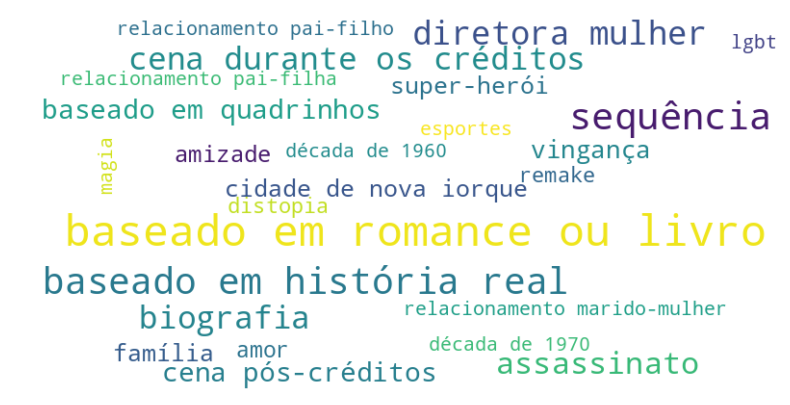

['based on novel or book', 'sequel', 'based on true story', 'woman director', 'biography', 'duringcreditsstinger', 'murder', 'based on comic', 'aftercreditsstinger', 'revenge', 'new york city', 'superhero', 'family', 'friendship', 'love', 'dystopia', 'remake', 'lgbt', '1970s', 'husband wife relationship', 'parent child relationship', 'sports', 'father daughter relationship', 'magic', '1960s']
Counter({('based on true story', 'biography'): 76, ('based on comic', 'superhero'): 62, ('aftercreditsstinger', 'duringcreditsstinger'): 54, ('based on novel or book', 'based on true story'): 41, ('aftercreditsstinger', 'superhero'): 39, ('aftercreditsstinger', 'based on comic'): 38, ('based on comic', 'duringcreditsstinger'): 38, ('duringcreditsstinger', 'superhero'): 35, ('based on novel or book', 'biography'): 33, ('duringcreditsstinger', 'sequel'): 33, ('aftercreditsstinger', 'sequel'): 30, ('based on novel or book', 'love'): 26, ('based on novel or book', 'sequel'): 24, ('based on novel or bo

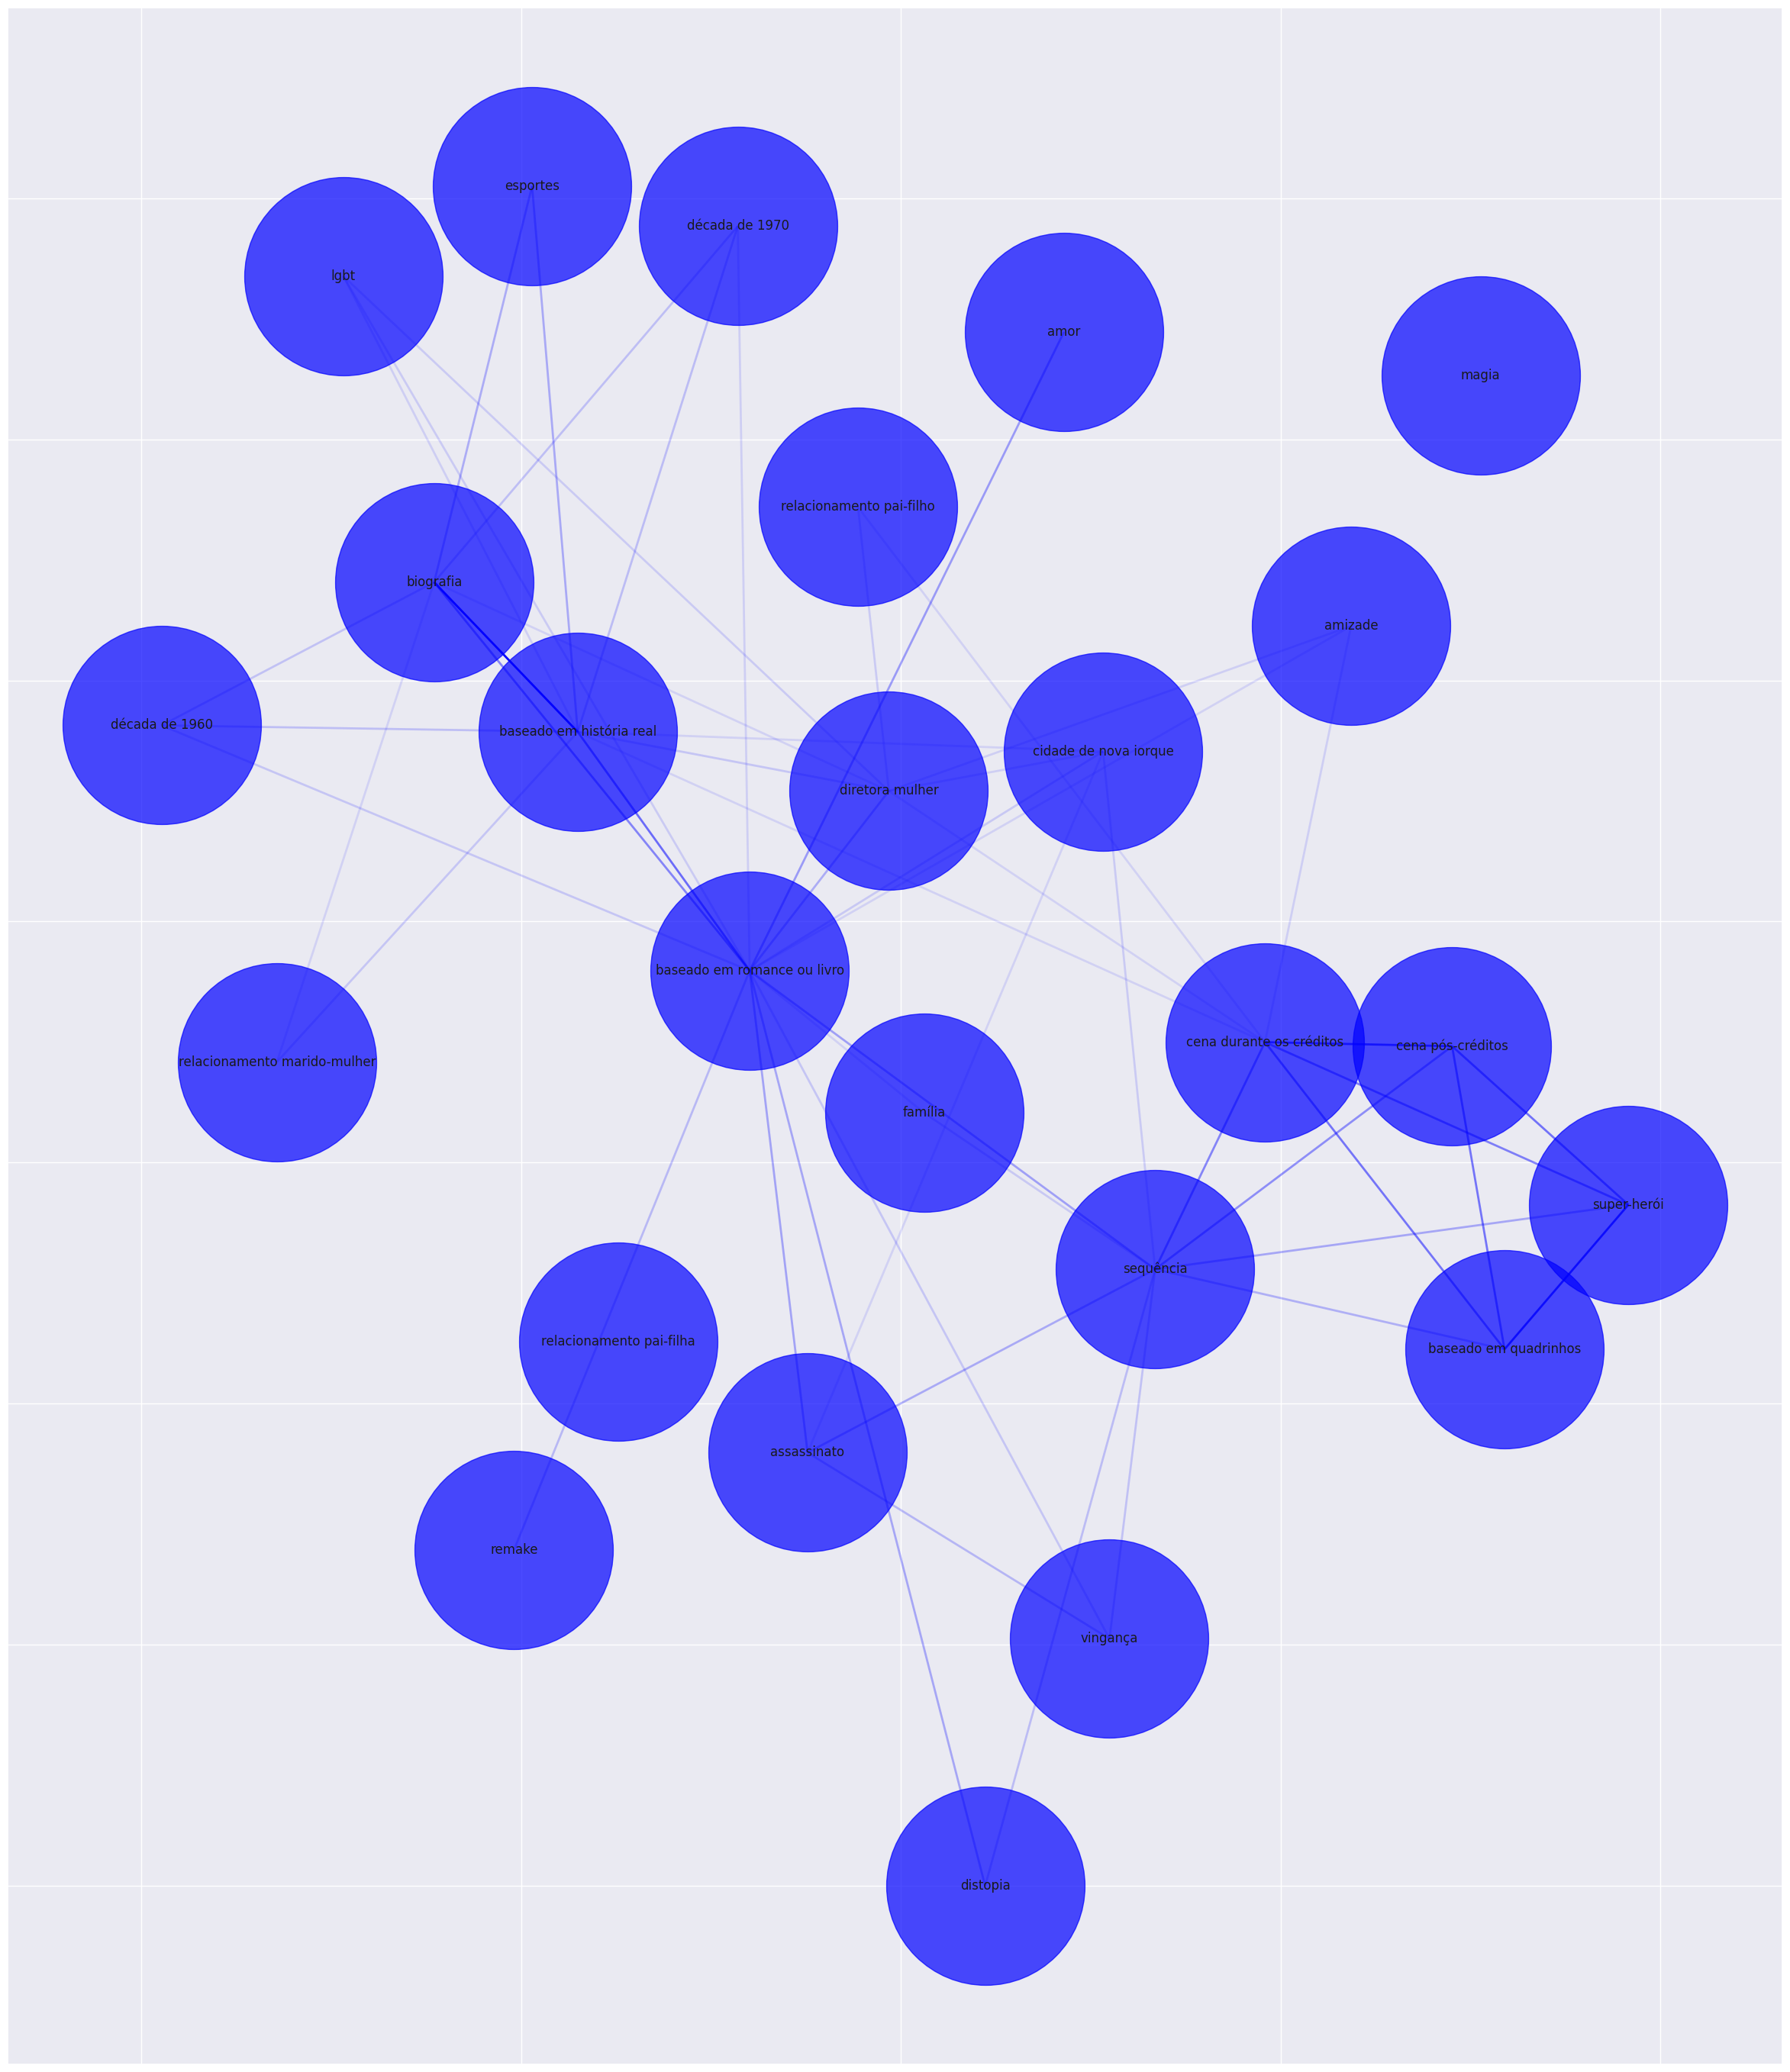

In [228]:
from wordcloud import WordCloud
from itertools import combinations
import networkx as nx

df = movies_data_by_year['all']

quantity_of_words = 25

# Mapa de palavaras para keywords
df['keywords'] =  df['keywords'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_keywords = df.explode('keywords', ignore_index=True).dropna(subset='keywords')['keywords']
all_keywords = [str(keyword).strip() for keyword in df_keywords]
keyword_counts = Counter(all_keywords)
keyword_counts_most_common = keyword_counts.most_common(quantity_of_words)

translated_keywords = {
    'based on novel or book': 'baseado em romance ou livro',
    'sequel': 'sequência',
    'based on true story': 'baseado em história real',
    'woman director': 'diretora mulher',
    'biography': 'biografia',
    'duringcreditsstinger': 'cena durante os créditos',
    'murder': 'assassinato',
    'based on comic': 'baseado em quadrinhos',
    'aftercreditsstinger': 'cena pós-créditos',
    'revenge': 'vingança',
    'new york city': 'cidade de nova iorque',
    'superhero': 'super-herói',
    'family': 'família',
    'friendship': 'amizade',
    'love': 'amor',
    'lgbt': 'lgbt',
    'dystopia': 'distopia',
    'remake': 'remake',
    'husband wife relationship': 'relacionamento marido-mulher',
    '1970s': 'década de 1970',
    '1960s': 'década de 1960',
    'parent child relationship': 'relacionamento pai-filho',
    'magic': 'magia',
    'sports': "esportes",
    'father daughter relationship': 'relacionamento pai-filha'
}

keyword_counts_translated = [(translated_keywords.get(keyword, keyword), count) for keyword, count in keyword_counts_most_common]


keyword_counts_dict = {k: v for k, v in keyword_counts_translated}
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts_dict)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
# plt.title(f'Word Cloud das Keywords')
plt.show()

keywords_filter_list = [k for k,v in keyword_counts_most_common]
print(keywords_filter_list)

co_occurrence_counts = Counter()
for keywords in df['keywords']:
    filtered_keywords = [keyword for keyword in keywords if keyword in keywords_filter_list]
    co_occurrence_counts.update(Counter(combinations(sorted(filtered_keywords), 2)))

G = nx.Graph()

print(co_occurrence_counts)

max_co_occurrence = co_occurrence_counts.most_common(1)[0][1]
for (keyword1, keyword2), count in co_occurrence_counts.items():
    # norm = float(count) / max_co_occurrence
    norm = float(count) / max_co_occurrence
    G.add_edge(translated_keywords[keyword1], translated_keywords[keyword2], weight=norm)
    
pos = nx.spring_layout(G, k=0.4)

# Desenhando o grafo
plt.figure(figsize=(30, 35))

# Desenhando as arestas com pesos
max_weight = max((data['weight'] for u, v, data in G.edges(data=True)))
edges = nx.draw_networkx_edges(
    G, pos, edge_color='blue', alpha=[G[u][v]['weight'] if G[u][v]['weight'] > 0.1 else 0 for u, v in G.edges()],
    width=2
)

# Desenhando os nós com tamanhos proporcionais à frequência
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=35000,
    node_color='blue', alpha=0.7
)

# Desenhando os rótulos dos nós
labels = nx.draw_networkx_labels(G, pos, font_size=12)

# plt.title('Grafo de Co-Ocorrência das Keywords')
plt.show()



0       Comédia
1         Drama
2       Romance
3         Crime
4       Comédia
         ...   
7100    Comédia
7101    Romance
7102    Comédia
7103      Drama
7104    Comédia
Name: genres, Length: 7104, dtype: object


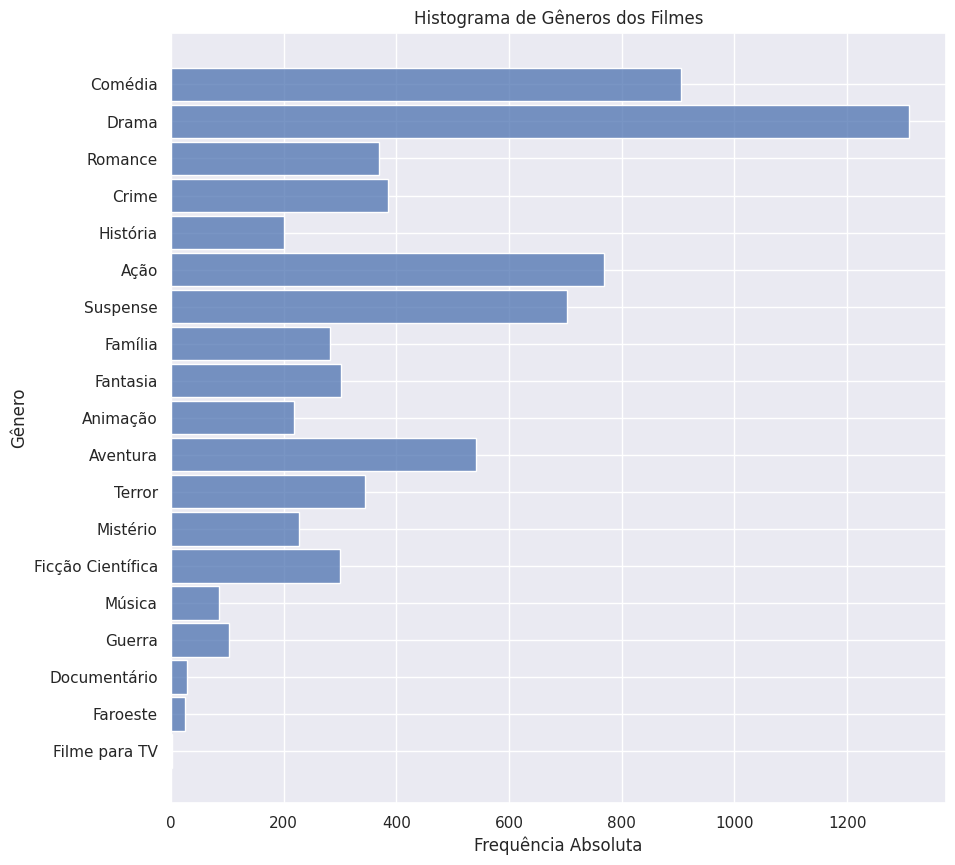

In [229]:
genre_translation = {
    'Action': 'Ação',
    'Adventure': 'Aventura',
    'Animation': 'Animação',
    'Comedy': 'Comédia',
    'Crime': 'Crime',
    'Documentary': 'Documentário',
    'Drama': 'Drama',
    'Family': 'Família',
    'Fantasy': 'Fantasia',
    'History': 'História',
    'Horror': 'Terror',
    'Music': 'Música',
    'Mystery': 'Mistério',
    'Romance': 'Romance',
    'Science Fiction': 'Ficção Científica',
    'Thriller': 'Suspense',
    'TV Movie': 'Filme para TV',
    'War': 'Guerra',
    'Western': 'Faroeste'
}

def translate_genres(genres, translation_dict):
    return [translation_dict.get(genre, genre) for genre in genres]

df = movies_data_by_year['all']
df['genres'] = df['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_genres = df.explode('genres', ignore_index=True).dropna(subset='genres')
df_genres['genres'] = df_genres['genres'].apply(lambda x:genre_translation[x])
print(df_genres['genres'])
# print(df_genres)

# all_genres = [genre for sublist in df['genres'] for genre in sublist]
plt.figure(figsize=(10, 10))
sns.histplot(data=df_genres, y='genres', discrete=True, shrink=0.9)
plt.title('Histograma de Gêneros dos Filmes')
plt.xlabel('Frequência Absoluta')
plt.ylabel('Gênero')
# plt.xticks(rotation=45)
plt.show()


Análise de Gêneros do Elenco

In [282]:
gender_translation = {
    "Not set/not specified": "Não definido / Não especificado",
    "Female": "Mulher",
    "Male": "Homem",
    "Non-binary": "Não binário"
}

df = movies_data_by_year['all']
df["release_date"] = pd.to_datetime(df["release_date"])
df['year'] = df['release_date'].dt.year

df["cast"] = df["cast"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df_exploded = df.explode('cast')

# separa cada key do objeto em uma coluna
df_normalized = pd.concat([df_exploded.drop(['cast'], axis=1), df_exploded['cast'].apply(pd.Series)], axis=1)

gender_counts_per_year = df_normalized.groupby(['year', 'gender']).size().reset_index(name='count')
gender_counts_per_year = gender_counts_per_year.sort_values(by=['year', 'gender'])

gender_counts_per_year['gender'] = gender_counts_per_year['gender'].apply(lambda x:gender_translation[x])


total_counts_per_year = df_normalized.groupby('year').size().reset_index(name='total_count')


gender_counts_per_year_merged = gender_counts_per_year.merge(total_counts_per_year, on='year')
gender_counts_per_year_merged['percentage'] = (gender_counts_per_year_merged['count'] / gender_counts_per_year_merged['total_count']) * 100
gender_counts_per_year_merged = gender_counts_per_year_merged.sort_values(by=['year', 'gender'])

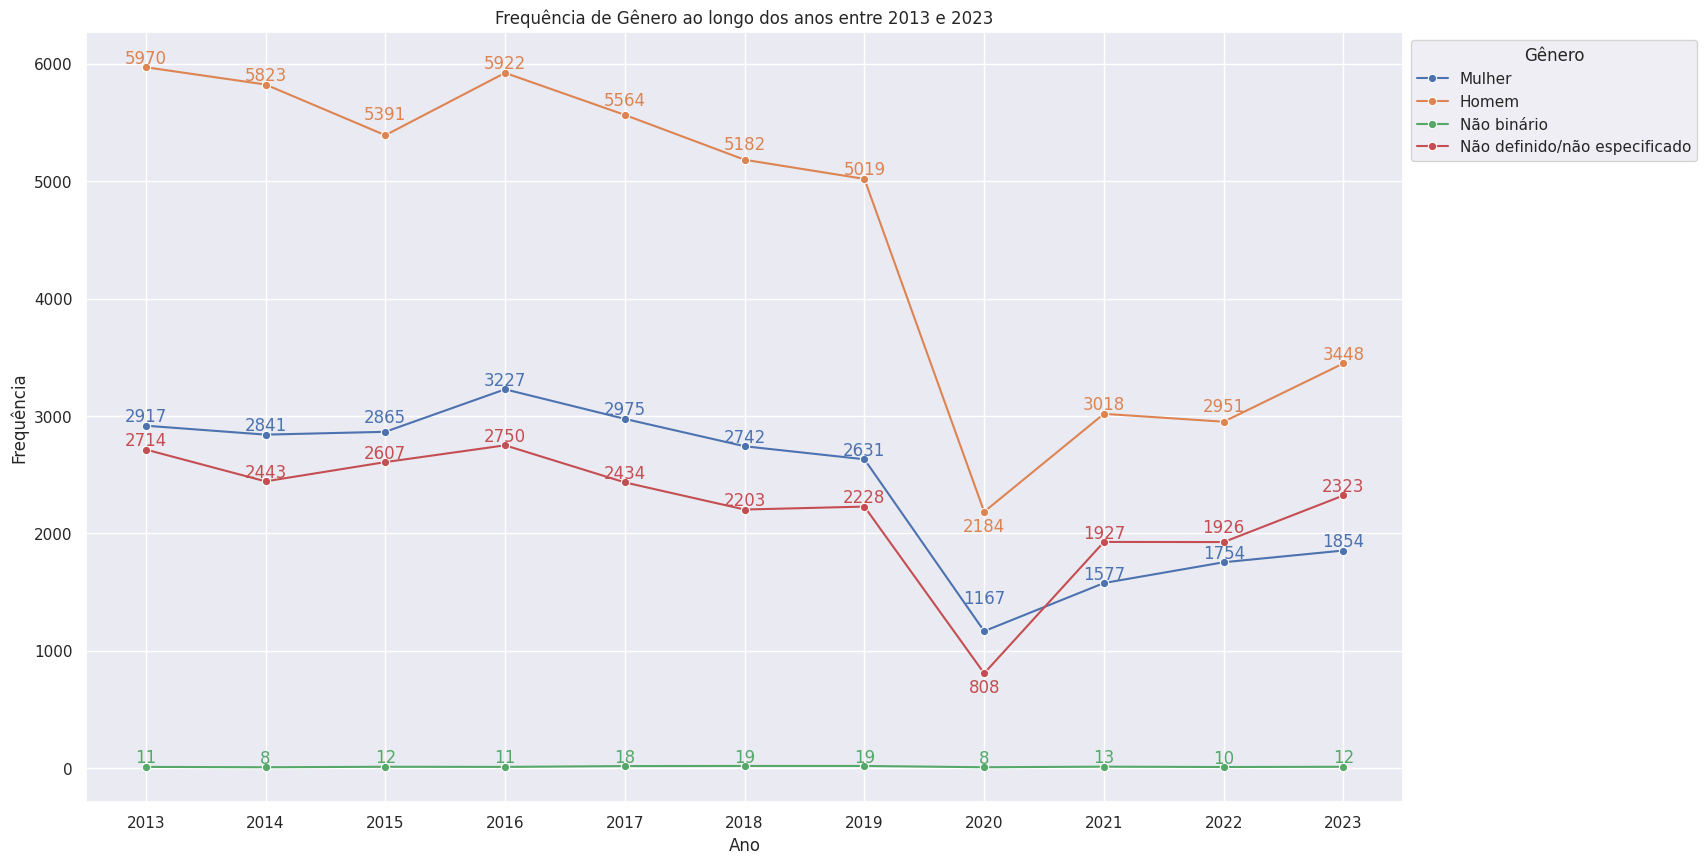

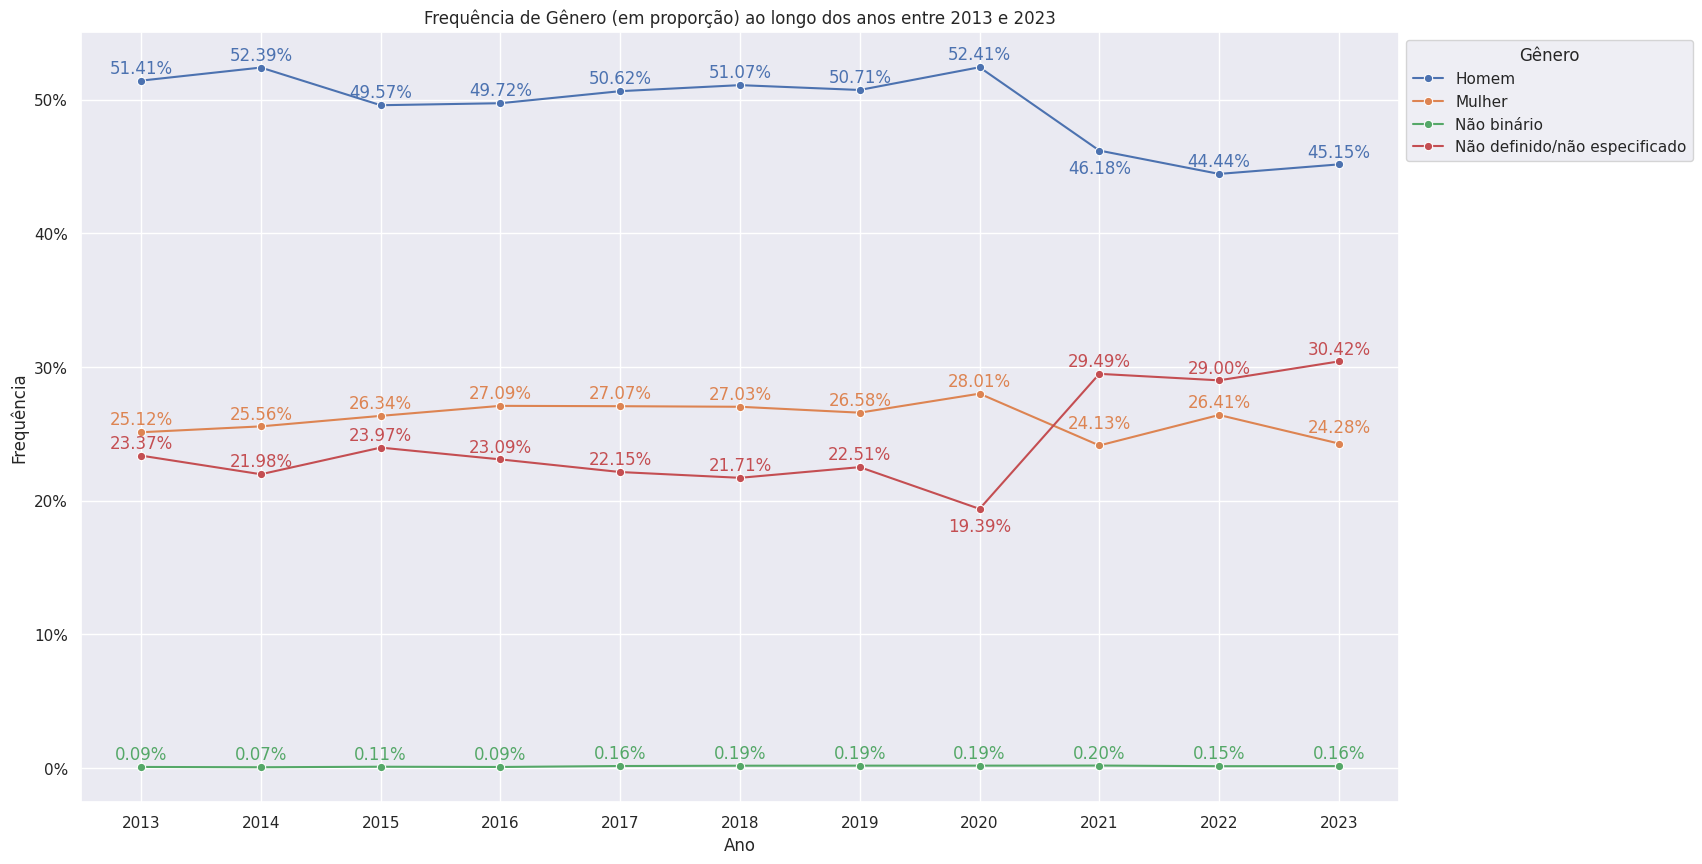

In [281]:
from matplotlib.ticker import FuncFormatter

pos_format = {
    5391: 100,
    5564: 50,
    5182: 50,
    2184: -200,
    2951: 50,
    2447: 50,
    808: -200,
    1926: 50,
    1167: 200,
    2865: 50,
}

plt.figure(figsize=(17, 10))
plot = sns.lineplot(data=gender_counts_per_year, x='year', y='count', hue='gender', marker='o')
plt.xticks(ticks=range(gender_counts_per_year['year'].min(), gender_counts_per_year['year'].max() + 1))
for line in plot.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        if (int(y_value) in pos_format):
            plot.text(x_value, y_value + pos_format[int(y_value)], f'{y_value:.0f}', color=line.get_color(), ha="center", va="bottom")
        else:
            plot.text(x_value, y_value, f'{y_value:.0f}', color=line.get_color(), ha="center", va="bottom")
        

plt.title('Variação da Frequência absoluta de Gêneros nos Elencos de Filmes (2013-2023)')
plt.xlabel('Ano')
plt.ylabel('Frequência')
plt.legend(title='Gênero')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

pos_format = {
    46.18: -2,
    24.13: 0.5,
    19.39: -2,
    24.13: 1,
    24.28: 0.5
}

plt.figure(figsize=(17, 10))
plt.xticks(ticks=range(gender_counts_per_year_merged['year'].min(), gender_counts_per_year['year'].max() + 1))
plot = sns.lineplot(data=gender_counts_per_year_merged, x='year', y='percentage', hue='gender', marker='o', legend="full")

def percentage_formatter(x, pos):
    return f'{x:.0f}%'

for line in plot.lines:
    for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
        if (float(f'{y_value:.2f}') in pos_format):
            plot.text(x_value, y_value + pos_format[float(f'{y_value:.2f}')], f'{y_value:.2f}%', color=line.get_color(), ha="center", va="bottom")
        else:
            plot.text(x_value, y_value + 0.25, f'{y_value:.2f}%', color=line.get_color(), ha="center", va="bottom")
        
plot.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

plt.title('Frequência relativa de Gênero dos elencos entres 2013 e 2023')
plt.xlabel('Ano')
plt.ylabel('Frequência Absoluta')
plt.legend(title='Gênero')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))
plt.show()

,year,total_count
0,2013,11612
1,2014,11115
2,2015,10875
3,2016,11910
4,2017,10991
5,2018,10146
6,2019,9897
7,2020,4167
8,2021,6535
9,2022,6641
